# Westeros Tutorial
## Adding fossil resources - Part 1

In this tutorial we will cover the addition of fossil resources, i.e. resource supply curves, to the model.  This will include defining a `resource_volume` and respective costs.  Multiple resource categories can be added for a single commodity, allowing, for example, a differentiation to be made between '*reserves*' and '*resources*' and/or the location of the resources, i.e. above or below ground; on- or off-shore.

‘*Reserves*’ are generally defined as being those quantities for which geological and engineering information indicate with reasonable certainty that they can be recovered in the future from known reservoirs under existing economic and operating conditions. ‘*Resources*’ are detected quantities that cannot be profitably recovered with current technology, but might be recoverable in the future, as well as those quantities that are geologically possible, but yet to be found. Definitions are based on Rogner et al. (2012). 

In this tutorial, we will be adding two categories of coal resources.  The assumed potential is based on the coal requirements by the `coal_ppl` in the baseline, and will be split so that we can also observe the use of multiple resource categories. 

Two further tutorials on adding fossil resources are available, which will elaborate on the modelling of fossil resources. Part 2 will introduce the constraint `resource_remaining`, therefore specifying what share of these resources must be preserved over time.  In Part 3, we will further add a coal extraction technology, linking the coal resources to the primary energy level, which can be used to model energy requirements of the extraction process.

In [1]:
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [2]:
mp = ix.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at 'C:\Users\fricko\.local\ixmp\localdb\default'


## Load the existing scenario '*baseline*' and clone to a new scenario '*renewable_potential*' to which we will apply the `renewable_resource_constraints` constraint

In [3]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'fossil_resources', 'illustration of adding fossil resources', keep_solution=False)
scen.check_out()

## Retrieve parameters to perform subsequent addition of parameters and define 'base' dataframes for adding parameters

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

base_input = {
    'node_loc': country,
    'year_vtg': vintage_years
    ,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

## `resource_potential` and `grade`- Describing the fossil resource potentials

Introducing fossil resources requires the following steps to be carried out:
1. Add level and commodity required for resources:
   - Specify the new level and commodity which accounts for the coal resources.
   - Specify which level is a `resource`
2. Add potentials and corresponding parameters
   - Add `grade`
   - Add `resource_volume`
   - Add `resource_cost`
   - Add `historical_extraction`
3. Modify existing `coal_ppl` technology by adding a new `input` parameter.

From the '*baseline*' scenario we know that the `coal_ppl` required 3942 GWa of coal.  We will set the potentials so that sufficient coal is available for use bu the `coal_ppl`. A parameter `historical_extraction` is also introduced purly for demonstation purposes, although this will not impact the `resource_potentials`, i.e. `historical_extraction` is disregarded in the equation 'RESOURCE_CONSTRAINT'. Therefore, the potentials added will always reflect the resource availability as of the `firstmodelyear`.
NOTE: When cloning a scenario and shifting the firstmodelyear, the `resource_volume` will be automatically adjusted to reflected the amounts previously used.

### Add coal resources

In [5]:
# {grade: [volume, cost, share remaining, historical_extraction]}
potentials = {'a': [1000, 1.0, 280],
              'b': [2942, 6.0, 0]}

In [6]:
commodity= 'coal'
level = 'resource'
scen.add_set('commodity', commodity)
scen.add_set('level', level)
scen.add_set('level_resource', level)
for grade in potentials:
    scen.add_set('grade', grade)
    # index for resource_volume is ['node', 'commodity', 'grade', 'value', 'unit']
    df = pd.DataFrame({'node': [country],
                       'commodity': commodity,
                       'grade': grade,
                       'value': potentials[grade][0],
                       'unit': 'GWa'})
    scen.add_par('resource_volume', df)
       
    # index for resouce_cost is ['node', 'commodity', 'grade', 'year', 'value', 'unit']
    df = pd.DataFrame({'node': country,
                       'commodity': commodity,
                       'grade': grade,
                       'year': model_horizon.values.tolist(),
                       'value': potentials[grade][1],
                       'unit': 'GWa'})
    scen.add_par('resource_cost', df)
    
    # index for historical_extraction is ['node', 'commodity', 'grade', 'year', 'value', 'unit']
    df = pd.DataFrame({'node': country,
                       'commodity': commodity,
                       'grade': grade,
                       'year': [690],
                       'value':  potentials[grade][2],
                       'unit': 'GWa'})
    scen.add_par('historical_extraction', df)

### Adjust `coal_ppl` parameter `input` to establish link to the resources

In [7]:
df = make_df(base_input, technology='coal_ppl', commodity='coal', 
                   level='resource', value=1, unit='%')
scen.add_par('input', df)

### Commit and solve

In [8]:
scen.commit(comment='added coal resources')
scen.set_as_default()

In [9]:
scen.solve()

In [10]:
scen.var('OBJ')['lvl']

191942.265625

# Plotting Results

In [11]:
from tools import Plots
b = Plots(base, country, firstyear=700) # scenario: 'baseline' (without coal resource potential)
p = Plots(scen, country, firstyear=700) # scenario: 'fossil_resources' (baseline scenario with coal resource potentials)

## Activity
***
When comparing the results of the original scenario without coal resource potentials ('*baseline*') to the results of our newly modified scenario ('*fossil_resources*'), the activity of the both electricity generation technologies is the same.

### Scenario: '*baseline*'

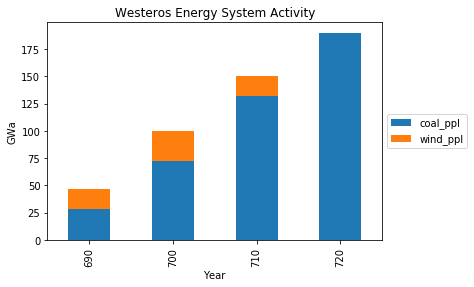

In [12]:
b.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Scenario: '*fossil_resource*'

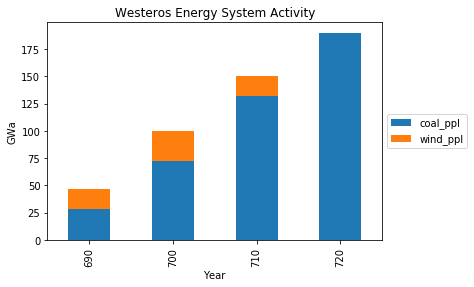

In [13]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

## Capacity
***
As is the case for activity, capacity also remains the same in both scenarios.

### Scenario: '*baseline*'

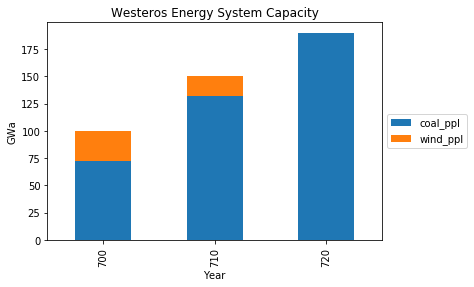

In [14]:
b.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Scenario: '*fossil_resource*'

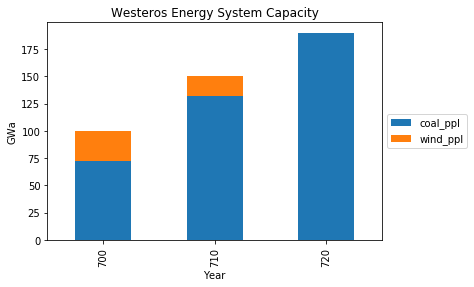

In [15]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

## Prices
***
The impact of introducing coal resources and therewith associated costs, only becomes noticeable when looking at prices for `light`.  Especially in the latter two timeperiods the impact is noticable, where prices increase compared to the '*baseline*' scenario.

### Scenario: '*baseline*'

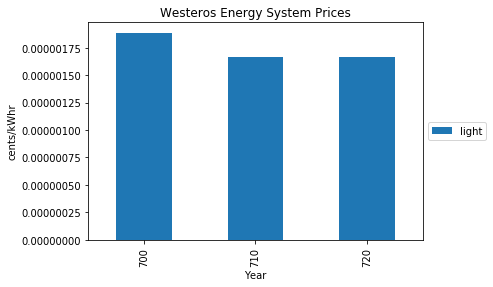

In [16]:
b.plot_prices(subset=['light'], baseyear=True)

### Scenario: '*fossil_resource*'

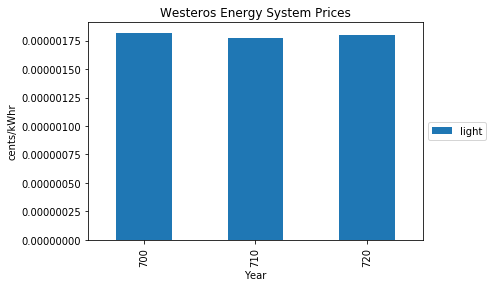

In [17]:
p.plot_prices(subset=['light'], baseyear=True)

## Extraction
***
Looking at the extraction over time, we can see that the model uses up the available potential of the cheaper `grade a` early on.  The switch to the more expensive `grade b` as of 710, is the reason for the price increase of `light`.

### Scenario: '*fossil_resource*'

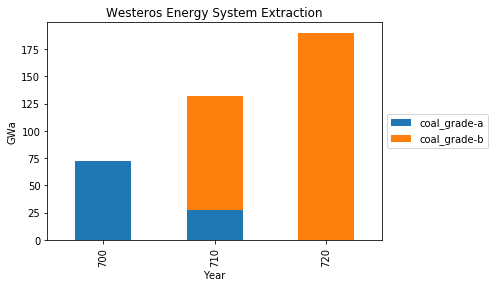

In [18]:
p.plot_extraction(subset=['coal'], baseyear=True, bygrade=True)

In [19]:
mp.close_db()